In [1]:
from datasets import load_dataset

dataset = load_dataset("Villian7/Emotions_Data", split="train+validation+test")

Found cached dataset parquet (/home/diwank/.cache/huggingface/datasets/Villian7___parquet/Villian7--Emotions_Data-49b3215fdc566f98/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [2]:
labels = set(dataset["label_text"])
labels

{'admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'neutral',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'sarcasm',
 'surprise'}

In [3]:
# LOTS of examples have the label text in the sample itself, remove those
filtered_dataset = dataset.filter(lambda r: r["label_text"] not in r["text"].lower())

len(filtered_dataset), len(dataset)

Filter:   0%|          | 0/1363078 [00:00<?, ? examples/s]

(1223886, 1363078)

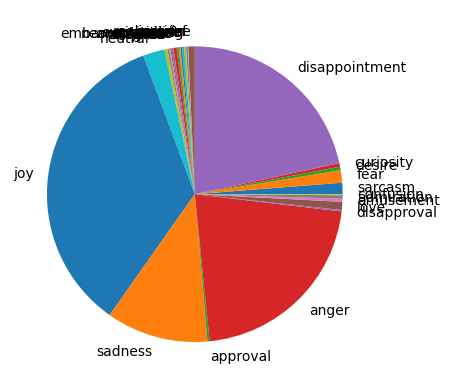

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# if using a Jupyter notebook, includue:
%matplotlib inline

label_count_map = {}

for row in dataset:
    label = row["label_text"]
    
    if label in label_count_map:
        label_count_map[label] += 1
    else:
        label_count_map[label] = 1

labels, y = label_count_map.keys(), label_count_map.values()
plt.pie(list(y), labels=list(labels))
plt.show() 

In [5]:
from pprint import pprint

pprint(label_count_map)

{'admiration': 5106,
 'amusement': 4566,
 'anger': 293537,
 'annoyance': 4687,
 'approval': 3267,
 'caring': 2712,
 'confusion': 1539,
 'curiosity': 5417,
 'desire': 5181,
 'disappointment': 294756,
 'disapproval': 2116,
 'disgust': 4502,
 'embarrassment': 2987,
 'excitement': 2524,
 'fear': 18499,
 'gratitude': 3181,
 'grief': 851,
 'joy': 471144,
 'love': 12050,
 'nervousness': 1825,
 'neutral': 32198,
 'optimism': 2494,
 'pride': 1574,
 'realization': 2393,
 'relief': 2985,
 'remorse': 2610,
 'sadness': 151693,
 'sarcasm': 16922,
 'surprise': 9762}


In [6]:
# Randomly take up to 2000 each

from tqdm.auto import tqdm

dataset = dataset.shuffle()

samples = {
    label: [] for label in label_count_map.keys()
}

num_to_take = 2000

for row in tqdm(dataset, total=len(dataset)):
    label = row["label_text"]

    if len(samples[label]) > num_to_take:
        continue
    else:
        samples[label].append(row)

  0%|          | 0/1363078 [00:00<?, ?it/s]

In [7]:
from datasets import Dataset
subset_ds = Dataset.from_list([
    item
    for cluster in samples.values()
    for item in cluster
])

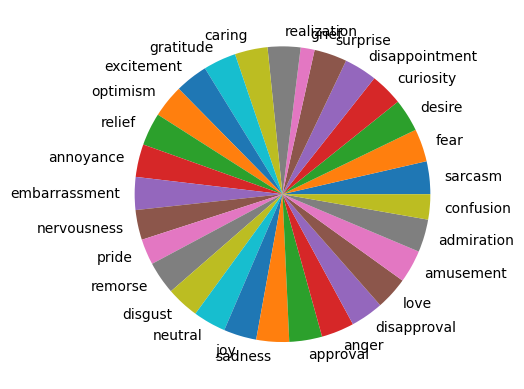

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# if using a Jupyter notebook, includue:
%matplotlib inline

label_count_map = {}

for row in subset_ds:
    label = row["label_text"]
    
    if label in label_count_map:
        label_count_map[label] += 1
    else:
        label_count_map[label] = 1

labels, y = label_count_map.keys(), label_count_map.values()
plt.pie(list(y), labels=list(labels))
plt.show() 

In [9]:
raise 1//0

ZeroDivisionError: integer division or modulo by zero

In [ ]:
def to_dialog(row):
    from tenacity import (
        retry,
        stop_after_attempt,
        wait_random_exponential,
    )

    import openai
    openai.api_key = "XXX"

    INSTRUCTION = """A"""

    from redis import StrictRedis
    from redis_cache import RedisCache

    client = StrictRedis(host="localhost", decode_responses=True)
    cache = RedisCache(redis_client=client)

    @cache.cache()
    @retry(wait=wait_random_exponential(min=1, max=90), stop=stop_after_attempt(100))
    def completion_with_backoff(sample):

        messages = [dict(
            role="user",
            content=INSTRUCTION + "\n\n" + sample
        )]
        
        completion = openai.ChatCompletion.create(
            model="gpt-4",
            messages=messages,
            temperature=0.05,
        )
        
        result = completion.choices[0].message["content"]
        return result

    completion = completion_with_backoff(row["text"])
    row["dialog"] = completion
    return row

In [ ]:
dataset = dataset.map(to_dialog, num_proc=20)

In [ ]:
from datetime import datetime, timedelta
import random
from random import randrange
import re

import names

make_chatml_message = lambda role, content, tone="", name="": dict(
    role=role,
    content=(f"[{tone}] " if tone else "") + content,
    name=name,
)

def transform_to_chatml(sample):
    
    dialog = sample["dialog"]
    dialog = dialog.replace("HUMAN\n", "THEODORE\n")
    dialog = dialog.replace("AI\n", "SAMANTHA\n")
    dialog = dialog.replace("THEODORE (human)", "THEODORE")
    dialog = dialog.replace("THEODORE (HUMAN)", "THEODORE")
    dialog = dialog.replace("SAMANTHA (AI)", "SAMANTHA")
    
    dialog = re.sub(r'^.*?(THEODORE|SAMANTHA)', r'\1', dialog, flags=re.DOTALL)

    # Container for adding messages
    messages = []
    person_name = names.get_first_name(gender="female")
    
    # Add system messages
    messages.append(make_chatml_message(
        role="system",
        name="situation",
        content=f"Samantha is talking to {person_name} about topics that she is interested in.",
    ))

    # Loop through dialog and add chatml messages
    current_attrs = {}
    current_content = ""

    for line in dialog.split("\n"):
        line = line.strip()
        
        # Something else
        if line.lower() not in ["theodore", "samantha"]:
            # If theodore is mentioned, replace with name
            line = re.sub(r'theodore', person_name, line, flags=re.I)
            current_content += "\n" + line

        else:
            if current_content:
                try:
                    messages.append(make_chatml_message(
                        content=current_content.strip(), 
                        **current_attrs,
                    ))
                except Exception as e:
                    print(e)
                
                # reset
                current_content = ""
                current_attrs = {}

            is_samantha = line.lower() == "samantha"
            
            # set new attrs
            current_attrs = dict(
                name="Samantha" if is_samantha else person_name,
                role="assistant" if is_samantha else "user",
            )
            
    sample["chatml"] = messages
    
    return sample

In [ ]:
dataset = dataset.map(transform_to_chatml)
print(dataset[10]["chatml"])

In [ ]:
dataset.push_to_hub("diwank/samantha-dalio-chatml", private=True)